# Problem Set 2
## UCSF NS248, Winter 2023

### Solutions by Max Collard

---

In [1]:
import itertools

import numpy as np
import scipy.integrate as sint
import scipy.stats as sstats
import matplotlib.pyplot as plt

from tqdm import tqdm

---

## General notes

* Why do we do hypothesis testing?
    * Ideally, other than "because we have to"

---

## Problem 1

> Write a function that generates a gaussian distribution given three inputs:
> 1) the x coordinates for the points to be returned,
> 2) the mean and
> 3) the standard deviation.
>
> e.g. `f = gaussian(xvals, mean, stdev)`

In [2]:
def gaussian_pdf( mean = 0., stdev = 1. ):
    """Returns a function that evaluates a Gaussian pdf (default: standard normal)"""
    return lambda xs: ( (1./(stdev * np.sqrt( 2. * np.pi )))
                        * np.exp( -(1./2) * np.power( (xs - mean) / stdev, 2 ) ) )

> Use this function to generate a gaussian from -6 to 6 with 10000 points, a mean of 0 and a standard deviation of 1. Plot the CDF of this distribution and use the CDF to estimate the probability that a random draw from this gaussian distribution would be
> 
> a. 1 standard deviation or more from the mean.
>
> b. 2 standard deviations or more from the mean.
>
> c. 3 standard deviations or more from the mean.

In [3]:
xs = np.linspace( -6, 6, 10000 )
pdf = gaussian_pdf( mean = 1., stdev = 1.5 )
pdf_values = pdf( xs )

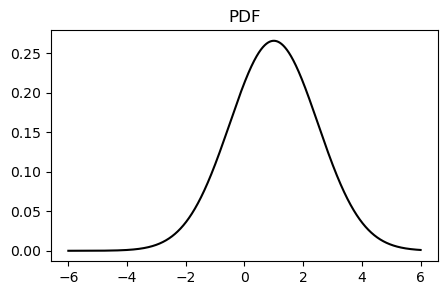

In [4]:
plt.figure( figsize = (5, 3) )
plt.plot( xs, pdf_values, 'k-' )
plt.title( 'PDF' )
plt.show()

In [5]:
def pdf_to_cdf( pdf, xs ):
    """Given a function that evaluates a pdf, determine the cdf using trapezoidal integration"""
    # We have to append a 0 because the integrator returns a value for each dx, not each x
    return np.r_[0, sint.cumulative_trapezoid( pdf( xs ), xs )]

In [6]:
cdf_values = pdf_to_cdf( pdf, xs )

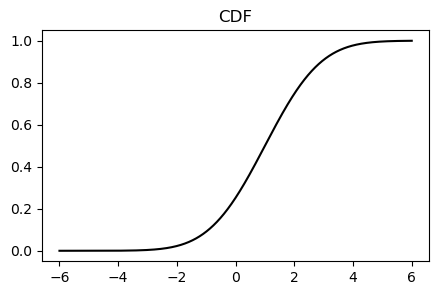

In [7]:
plt.figure( figsize = (5, 3) )
plt.plot( xs, cdf_values, 'k-' )
plt.title( 'CDF' )
plt.show()

In [8]:
def function_interpolator_lattice( xs, ys ):
    """Given arrays approximating a function `ys` = f(`xs`), return an interpolator function"""
    return lambda x_new: np.interp( x_new, xs, ys )

In [9]:
cdf = function_interpolator_lattice( xs, cdf_values )

The probability of being $v$ standard deviations or more from the mean is the sum of two parts:

* The left side: $\operatorname{CDF}(-a)$
    * This is defined to be $\operatorname{Pr}(X \leq v)$
* The right side: $1 - \operatorname{CDF}(v)$
    * This is because $\operatorname{Pr}(X \geq v) = \operatorname{Pr}((X \leq v)^c) = 1 - \operatorname{Pr}(X \leq v)$

In [10]:
questions = {
    '1a': 1,
    '1b': 2,
    '1c': 3
}

answers = { q: cdf( -v) + (1 - cdf( v ))
            for q, v in questions.items() }

In [11]:
answers

{'1a': 0.5912112445123967, '1b': 0.2752426866157127, '1c': 0.09504162852538939}

---

## Problem 2

> Generate 1000 random draws from the gaussian distribution you generated in question 2 using its CDF and uniform random numbers between 0 and 1. Verify the answers to 2a, b and c. Suggestion: Write a general purpose random draw function that takes as its input a CDF and the number of points to draw.

Note that if $U \sim \operatorname{Uniform}(0, 1)$, and $F$ is the CDF of some distribution $\mathcal{D}$, then
$$ F^{-1}(U) \sim \mathcal{D} $$

#### Proof sketch

Note that the CDF of $F^{-1}(U)$ is identical to $F$:

$$
\begin{eqnarray*}
    \operatorname{Pr}(F^{-1}(U) \leq x) & = & \operatorname{Pr}(U \leq F(x)) \\
        & = & F(x)
\end{eqnarray*}
$$

(here the second step comes from the observation that $\operatorname{Pr}(U \leq p) = p$, which we leveraged to simulate probabilistic firing in the last problem set.)

In [12]:
def function_inverse_interpolator_lattice( xs, ys ):
    """Return a function that computes an interpolated version of the inverse of f(`xs`) = `ys`"""
    return lambda y_new: np.interp( y_new, ys, xs )

In [13]:
def random_generator( cdf_xs, cdf_values ):
    """Return a function that generates a random variable from a distribution specified by the given cdf"""
    f = function_inverse_interpolator_lattice( cdf_xs, cdf_values )
    def gen( size = (1,) ):
        u = np.random.uniform( size = size )
        return f( u )
    return gen

In [14]:
xs = np.linspace( -6, 6, 10000 )

pdf = gaussian_pdf()
pdf_values = pdf( xs )
cdf_values = pdf_to_cdf( pdf, xs )
generator = random_generator( xs, cdf_values )

values = generator( size = (1000,) )

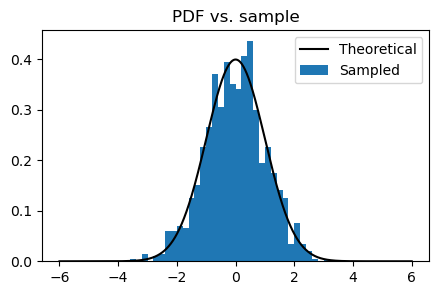

In [15]:
plt.figure( figsize = (5, 3) )

plt.plot( xs, pdf_values, 'k-',
          label = 'Theoretical' )
plt.hist( values,
          bins = np.arange( -6, 6, 0.2 ),
          density = True,
          label = 'Sampled' )

plt.legend()
plt.title( 'PDF vs. sample' )

plt.show()

---

## Problem 3

> Suppose you are performing a behavioral experiment where you measure the amount of time it takes for two groups of mice (wild-type and knockout) to find the hidden platform in a Morris Water Maze. Assume that you have 10 mice in each group and that after learning the escape latency is distributed as a gaussian.

> a. If the actual standard deviations are 10 seconds for both groups, the actual mean time for group 1 is 20 seconds and the actual mean time for group 2 is 30 seconds, what is the probability that you will detect the difference between the groups? The easiest way to do this is to simulate the data and see how often the differences come out significant.

In [16]:
def simulate( group_ns, group_means, group_stds,
              method = 'np',
              n_points = 10000,
              n_std = 10 ):
    """Simulate groups of iid Gaussian draws with the given parameters
    
    Keyword arguments:
    * `method`: the random number generator method to use
        * `np` (default) uses `numpy` built-ins
        * `mine` uses the demo functions created for the above problems; this has
            the additional parameters `n_points` (the number of CDF points used for
            interpolation) and `n_std` (the number of standard deviations away from
            the mean to compute tails for the CDF)
    """
    
    # Check to see that all the groups have their parameters defined
    if group_means.keys() != group_stds.keys():
        raise ValueError( 'Malformed parameters.' )
    if group_ns.keys() != group_means.keys():
        raise ValueError( 'Malformed parameters.' )
    
    # Create random number generators for each group
    group_generators = dict()
    for group in group_means.keys():
        
        if method == 'np':
            # Use the `numpy` built-in random methods for speed
            # This defines a random generator function that has the same arguments as what I
            #   made in `random_generator`
            def gen( size = (1,) ):
                return np.random.normal( loc = group_means[group],
                                         scale = group_stds[group],
                                         size = size )
            group_generators[group] = gen
            
        elif method == 'mine':
            # Use my hand-made Gaussian generator as a demo
            
            xs = np.linspace( group_means[group] - (n_std * group_stds[group]),
                              group_means[group] + (n_std * group_stds[group]), n_points )
            pdf = gaussian_pdf( mean = group_means[group],
                                stdev = group_stds[group] )
            pdf_values = pdf( xs )
            cdf_values = pdf_to_cdf( pdf, xs )
            group_generators[group] = random_generator( xs, cdf_values )
    
    # Use the random number generators of whatever method to generate data for each group
    data = dict()
    for group, generator in group_generators.items():
        data[group] = generator( size = (group_ns[group],) )
    
    return data

In [17]:
def evaluate( data,
              test = sstats.ttest_ind ):
    """Return the p-value for the given `test` between all of the groups in the given `dict` of `data`
    
    (Default is `scipy.stats.ttest_ind`)
    """
    
    # This ensures there is a unique (sorted) order to the groups
    groups = list( sorted( data.keys() ) )
    
    ret = dict()
    # Iterate across all possible comparisons between two groups
    for group_a, group_b in itertools.combinations( groups, 2 ):
        ret[(group_a, group_b)] = test( data[group_a], data[group_b] ).pvalue
    return ret

### Parameters

In [18]:
group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 20,
    'B': 30,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 10000
comparison_key = ('A', 'B')

alpha = 0.05

### Run: $t$-test

In [19]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6192.26it/s]


The power is the probability of rejecting the null hypothesis:

In [20]:
power = np.sum( ps_comparison < alpha ) / n_runs
print( f'Power: {power}' )

Power: 0.5585


### Aside: Nonparametric test (Wilcoxon rank-sum)

Compare this for the situation with a nonparametric test:

In [21]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    # Here we'll swap out the nonparametric `ranksums` test to use instead
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ),
                       test = sstats.ranksums )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3003.07it/s]


In [22]:
power = np.sum( ps_comparison < alpha ) / n_runs
print( f'Power: {power}' )

Power: 0.5545


In this particular case, we lose a *little* power, but not much.

> b. Suppose that the two populations are actually identical, and that both have a mean time of 25 seconds and a standard deviation of 10. Simulate the experiment 1000 times (e.g. do random draws to get a set of times for each group) and determine how often a two sample $t$-test returns a significance result at the default significance level. How is that number of incorrect outcomes related to the significance level?

### Parameters

In [23]:
group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 15,
    'B': 15,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 10000
comparison_key = ('A', 'B')

alpha = 0.05

### Usual significance threshold ($\alpha = 0.05$)

In [24]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6171.26it/s]


The empirical type I error is the probability of rejecting the null hypothesis under the null hypothesis:

In [25]:
alpha_empirical = np.sum( ps_comparison < alpha ) / n_runs
print( f'Expected Type I error:  {alpha}' )
print( f'Empirical Type I error: {alpha_empirical}' )

Expected Type I error:  0.05
Empirical Type I error: 0.0526


That matches the significance threshold pretty well!

### Varying the significance threshold

In [26]:
alphas_test = np.arange( 0.005, 0.11, 0.005 )

alphas_empirical = np.zeros( alphas_test.shape )
for i_alpha, alpha in tqdm( enumerate( alphas_test ),
                            total = len( alphas_test ) ):
    ps_comparison = []
    for i_run in range( n_runs ):
        run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
        ps_comparison.append( run_ps[comparison_key] )
    ps_comparison = np.array( ps_comparison )
    alphas_empirical[i_alpha] = np.sum( ps_comparison < alpha ) / n_runs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.53s/it]


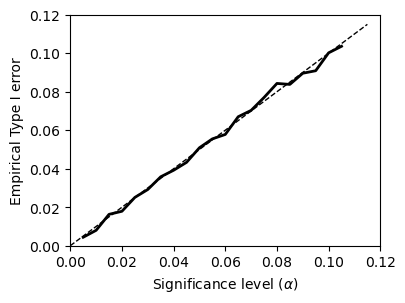

In [27]:
plt.figure( figsize = (4, 3) )

plt.plot( alphas_test, alphas_empirical, 'k-', linewidth = 2 )
plt.plot( [0, 0.115], [0, 0.115], 'k--', linewidth = 1 )

plt.xlabel( 'Significance level ($\\alpha$)' )
plt.ylabel( 'Empirical Type I error' )

plt.xlim( 0, 0.12 )
plt.ylim( 0, 0.12 )

plt.show()

Note that our observed Type I error tracks the significance level $\alpha$ of the test used quite well.

---

### Aside: Statistical significance is not itself statistically significant

Let's see what our error rate is if our test is not based on the actual differences, but is instead based on whether each group is different from the mean.

Say in this case that for groups A and B, we're looking at "changes from baseline". Here, we'll say that groups A and B are "different" if **one** is significantly different, but the other is **not**.

In [28]:
group_ns = {
    'A': 10,
    'B': 10,
}

overall_mean = 0.
group_means = {
    'A': overall_mean,
    'B': overall_mean,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 10000
comparison_key = ('A', 'B')

alpha = 0.05

In [29]:
# This allows us to use dot-notation in an easy way
from types import SimpleNamespace

def test_one_significant( alpha = 0.05,
                          mean_null = 0. ):
    """Return a statistical test with the following characteristics:
    
    * Return the significant p-value if *one* of the two groups is different from
        the null at significance level `alpha`, but not the other
    * Return 0.5 (not significant) if *both* or *neither* of the two grups is different
        from the null at significance level `alpha`
    
    (I.e., the returned `test` checks for a "difference in significance").
    """
    
    def test( data_a, data_b ):
        # Do 1-sample tests versus 0 for each group
        result_a = sstats.ttest_1samp( data_a, mean_null )
        result_b = sstats.ttest_1samp( data_b, mean_null )
        
        # Significant "difference": One shows a change, but not the other
        if result_a.pvalue < alpha and result_b.pvalue >= alpha:
            return SimpleNamespace( pvalue = result_a.pvalue )
        if result_b.pvalue < alpha and result_a.pvalue >= alpha:
            return SimpleNamespace( pvalue = result_b.pvalue )
        
        # Not significant: Either both show a change, or neither do
        return SimpleNamespace( pvalue = 0.5 )
    
    return test

In [30]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ),
                       test = test_one_significant( alpha = alpha ) )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4576.94it/s]


In [31]:
alpha_empirical = np.sum( ps_comparison < alpha ) / n_runs
print( f'Expected Type I error:  {alpha}' )
print( f'Empirical Type I error: {alpha_empirical}' )

Expected Type I error:  0.05
Empirical Type I error: 0.0977


So we see that the test "one of the groups is statistically different from the baseline but the other isn't" is actually **not** controlled at the $\alpha = 0.05$ significance level.

Note, however, that we can correct this:

In [32]:
individual_test_significance_cutoff = 0.025

In [33]:
ps_comparison = []
for i_run in tqdm( range( n_runs ) ):
    run_ps = evaluate( simulate( group_ns, group_means, group_stds ),
                       test = test_one_significant( alpha = individual_test_significance_cutoff ) )
    ps_comparison.append( run_ps[comparison_key] )
ps_comparison = np.array( ps_comparison )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4697.69it/s]


In [34]:
alpha_empirical = np.sum( ps_comparison < individual_test_significance_cutoff ) / n_runs
print( f'"Hoped-for" Type I error:        {alpha}' )
print( f'Significance cutoff alpha used:  {individual_test_significance_cutoff}' )
print( f'Empirical Type I error:          {alpha_empirical}' )

"Hoped-for" Type I error:        0.05
Significance cutoff alpha used:  0.025
Empirical Type I error:          0.0459


This can happen in your analyses in even more insidious ways than this.

This is why it's always best practice to **run your analysis code with simulated null data** in order to understand your true **empirical** type I error, and adjust thresholds accordingly.

---

### Aside: Violating assumptions increases Type I error

This isn't the case if the assumptions of our test don't match the data. For example, let's see what happens when we use an equal-variance $t$-test for data with unequal variance:

In [35]:
group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 15,
    'B': 15,
}

group_stds = {
    'A': 5,
    'B': 40,
}

n_runs = 10000
comparison_key = ('A', 'B')

alphas_test = np.arange( 0.005, 0.11, 0.005 )

# Specify our equal variance assumption for the test
test_equal_var = lambda xs, ys: sstats.ttest_ind( xs, ys, equal_var = True )

In [36]:
alphas_empirical = np.zeros( alphas_test.shape )
for i_alpha, alpha in tqdm( enumerate( alphas_test ),
                            total = len( alphas_test ) ):
    ps_comparison = []
    for i_run in range( n_runs ):
        run_ps = evaluate( simulate( group_ns, group_means, group_stds ),
                           test = test_equal_var )
        ps_comparison.append( run_ps[comparison_key] )
    ps_comparison = np.array( ps_comparison )
    alphas_empirical[i_alpha] = np.sum( ps_comparison < alpha ) / n_runs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.46s/it]


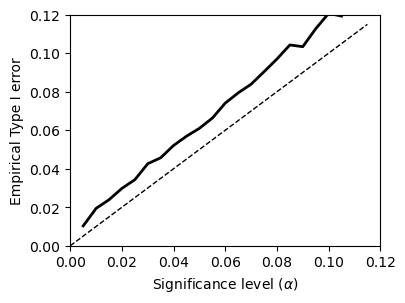

In [37]:
plt.figure( figsize = (4, 3) )

plt.plot( alphas_test, alphas_empirical, 'k-', linewidth = 2 )
plt.plot( [0, 0.115], [0, 0.115], 'k--', linewidth = 1 )

plt.xlabel( 'Significance level ($\\alpha$)' )
plt.ylabel( 'Empirical Type I error' )

plt.xlim( 0, 0.12 )
plt.ylim( 0, 0.12 )

plt.show()

As above, this is why it is always advised to **empirically check your type I error** using surrogate (simulated) null data.

---

> c. Suppose you were testing four pairs of groups (where each pair is independent and separate from the other pairs) with 10 mice each. What is the probability that one or more of the four tests would result in a significant difference at the $p < 0.05$ level?

### Theoretical

Under the null hypothesis, whether we reject the null hypothesis is a Bernoulli random variable with $p = \alpha$ by definition.

This means that the number of rejections $R$ of $N$ independent hypothesis tests is a binomial random variable, with $n = N$ and $p = \alpha$. So,

$$
\begin{eqnarray*}
    \operatorname{Pr}(R \geq 1) & = & 1 - \operatorname{Pr}(R < 1) \\
        & = & 1 - \operatorname{Pr}(R = 0) \\
        & = & 1 - \binom{N}{0}\,\alpha^0\,(1 - \alpha)^N \\
        & = & 1 - (1 - \alpha)^N
\end{eqnarray*}
$$

(as the $0$th binomial coefficient is always 1).

In general, the probability of having at least $1$ false positive amongst a set of hypotheses is known as the **familywise error rate** (FWER):

$$\textrm{FWER} = \operatorname{Pr}(R \geq 1)$$

### Parameters

In [38]:
n_pairs = 4

group_ns = {
    'A': 10,
    'B': 10,
}

group_means = {
    'A': 15,
    'B': 15,
}

group_stds = {
    'A': 10,
    'B': 10,
}

n_runs = 10000
comparison_key = ('A', 'B')

alpha = 0.05

pr_any_theoretical = 1. - np.power( 1 - 0.05, n_pairs )

In [39]:
ps_pairs = np.zeros( (n_pairs, n_runs) )
for i_run in tqdm( range( n_runs ) ):
    for i_pair in range( n_pairs ):
        run_ps = evaluate( simulate( group_ns, group_means, group_stds ) )
        ps_pairs[i_pair, i_run] = run_ps[comparison_key]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1686.32it/s]


In [40]:
reject_any = np.any( ps_pairs < alpha, axis = 0 )

In [41]:
pr_any_empirical = np.sum( reject_any ) / n_runs
print( f'Expected familywise error rate:  {pr_any_theoretical}' )
print( f'Empirical familywise error rate: {pr_any_empirical}' )

Expected familywise error rate:  0.18549375000000012
Empirical familywise error rate: 0.1868


---

### Aside: Multiple comparison corrections

#### Bonferroni

Presuppose the null hypothesis. Let $X_i$ be the $N$ individual outcomes of the tested hypotheses, such that $R = \sum_i X_i$ is the total number of rejections. Then we know that

$$ \operatorname{FWER} := \operatorname{Pr}(R \geq 1) \leq \sum_i \operatorname{Pr}(X_i = 1) $$

because for sure if we rejected at least one test (left side) then one of our tests was a rejection (right side). (The right side is generally an **overestimate** of the left side, because it ignores the possibility of overlapping rejections from multple tests).

Since each term on the right hand side is definitionally $\alpha$ (the probability of rejecting a single test uner the null hypothesis), then we have

$$ \operatorname{FWER} \leq \sum_i \alpha = N\,\alpha $$

Shower thought: Just choose a new $\alpha^\ast = \alpha / N$, and use that as our significance level. Then our new FWER is

$$ \operatorname{FWER}^\ast \leq N\,\alpha^\ast = N\,\frac{\alpha}{N} = \alpha $$

That's the **Bonferroni correction**: it makes it so that the probability of **1 or more rejections** under the null hypothesis is $\leq \alpha$.

Notice that this correction is **conservative** (because of the $\leq$): we're guaranteed to *control* the FWER to be below $\alpha$, but we might be doing so quite aggressively, depending on the statistics of our tests. There are slightly less aggressive versions of this available (e.g., Šidák), though they all have their own caveats.

#### False discovery rate

An alternative approach is to change what metric we care about. Instead of the FWER, we might try to control the **false discovery rate**,

$$ \operatorname{FDR} := \operatorname{Pr}(H_0\textrm{ is true} \mid \textrm{reject }H_0) $$

This is the **fraction of hypothesis rejections that we got wrong**. (Notice that, unlike the $p$-value or the FWER, this is something that is **actually actionable**: given a set of results that I say are significant, if I control $\operatorname{FDR} \leq \gamma$, then I know that the fraction of things I'm wrong about in the results I present due to chance is $\leq \gamma$.)

The controlling procedures for this are really cool and rely on the distribution of *ranks* of $p$-values among tests, but are beyond the scope of this course for the implementation details. To use them yourself, they are implemented in [`statsmodels.stats.multitest.fdrcorrection`](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html), which gives two options:

* `method = 'p'`: Benjamini/Hochberg, which applies when the tests are **positively correlated** (a low $p$-value on one test implies a low $p$-value on another test) or independent
* `method = 'n'`: Benjamini/Yekutieli, which applies when the tests are **negatively correlated** (a low $p$-value on one test implies a high $p$-value on another test)

You'll have to think about your data to know which one is appropriate!

Instead of $p$-values, when you use FDR correction, you get $q$-values. The intuition is as follows: the $p$ value can ge defined as

$$ p = \textrm{the lowest }\alpha\textrm{ such that the test comes out significant} $$

In a similar way, the $q$-value is defined as

$$ q = \textrm{the lowest FDR at which we could control for that still makes the test come out significant} $$

Note that this is a **very different** quantity from the $p$-value: the conditioning is completely backwards! (Recall that FDR is probability of null hypothesis given test rejection, while $\alpha$ is probability of test rejection given null hypothesis.) "FDR-corrected $p$-values" (which is what people call $q$-values in the literature) are **not at all comparable** to $p$-values!